In [1]:
! ls RegMz* >mz_fft.txt

In [2]:
!cat mz_fft.txt

RegMz_6_j_0.22918311805232927_beta_0.hdf5
RegMz_6_j_0.22918311805232927_beta_1.5.hdf5
RegMz_6_j_0.22918311805232927_beta_2.5.hdf5
RegMz_6_j_0.22918311805232927_beta_inf.hdf5
RegMz_6_j_0.6366197723675814_beta_0.hdf5
RegMz_6_j_0.6366197723675814_beta_1.5.hdf5
RegMz_6_j_0.6366197723675814_beta_2.5.hdf5
RegMz_6_j_0.6366197723675814_beta_inf.hdf5
RegMz_8_j_0.22918311805232927_beta_0.hdf5
RegMz_8_j_0.22918311805232927_beta_1.5.hdf5
RegMz_8_j_0.22918311805232927_beta_2.5.hdf5
RegMz_8_j_0.22918311805232927_beta_inf.hdf5
RegMz_8_j_0.6366197723675814_beta_0.hdf5
RegMz_8_j_0.6366197723675814_beta_1.5.hdf5
RegMz_8_j_0.6366197723675814_beta_2.5.hdf5
RegMz_8_j_0.6366197723675814_beta_inf.hdf5


RegMz_6_j_0.22918311805232927_beta_0.hdf5
RegMz_6_j_0.22918311805232927_beta_1.5.hdf5
RegMz_6_j_0.22918311805232927_beta_2.5.hdf5
RegMz_6_j_0.22918311805232927_beta_inf.hdf5
RegMz_6_j_0.6366197723675814_beta_0.hdf5
RegMz_6_j_0.6366197723675814_beta_1.5.hdf5
RegMz_6_j_0.6366197723675814_beta_2.5.hdf5
RegMz_6_j_0.6366197723675814_beta_inf.hdf5
RegMz_8_j_0.22918311805232927_beta_0.hdf5
RegMz_8_j_0.22918311805232927_beta_1.5.hdf5
RegMz_8_j_0.22918311805232927_beta_2.5.hdf5
RegMz_8_j_0.22918311805232927_beta_inf.hdf5
RegMz_8_j_0.6366197723675814_beta_0.hdf5
RegMz_8_j_0.6366197723675814_beta_1.5.hdf5
RegMz_8_j_0.6366197723675814_beta_2.5.hdf5
RegMz_8_j_0.6366197723675814_beta_inf.hdf5


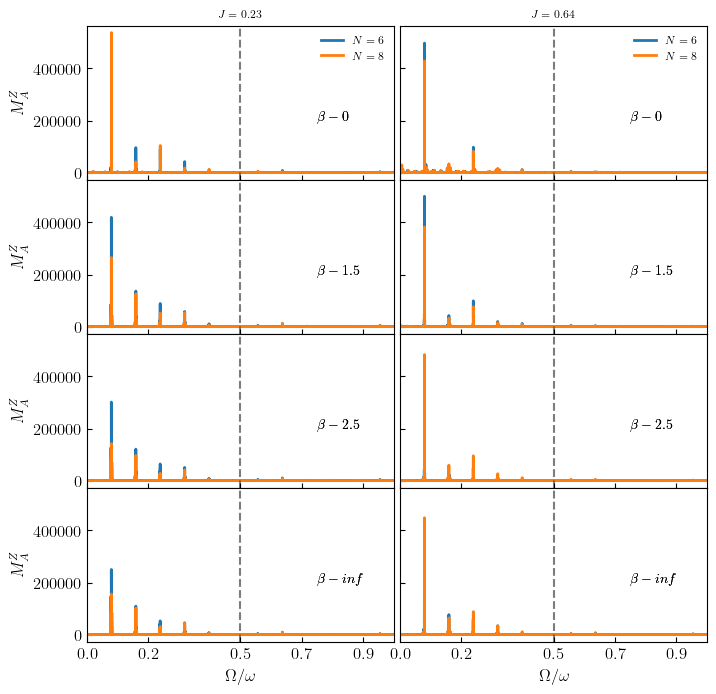

CPU times: user 4.61 s, sys: 678 ms, total: 5.29 s
Wall time: 5.61 s


In [11]:
%%time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks
from lmfit.models import LinearModel

plt.rcParams.update({"figure.figsize": (8,8),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 12,"font.sans-serif": ["Helvetica"]})
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

fig, axs = plt.subplots(4, 2, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.02, hspace=0.0)


freq_threshold = 0.1
legendftsize = 8

omega = 20.0
w = omega
T = 2 * np.pi/w


with open("mz_fft.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    #btfr = np.zeros((2,4))
    btfr = np.zeros((2,2,4))
    betas = np.zeros((2,4))
    Ns = np.zeros((2,2,4))
    
    for xx in range(0,x):
        filename = lines[xx][:-1]
        print(filename)
        
        with h5py.File(filename, "r") as f:
            mz_data_a = f['mza'][()]
            mz_data_b = f['mzb'][()]
            times = f['times'][()]            
            beta = f.attrs['beta']
            Jvalue = f.attrs['Jvalue']              
            N = f.attrs['N']
            w = f.attrs['w']
            
            T = 2 * np.pi/w
            
            if Jvalue == 0.072/T:
                jj = 0
                Jvalue1 = Jvalue
            if Jvalue == 0.2/T:
                jj = 1
                Jvalue2 = Jvalue
                
            infbeta = float('inf')
            
            if beta ==0:
                b = 0
            if beta ==1.5:
                b = 1
            if beta ==2.5:
                b = 2            
            if beta ==infbeta:
                b = 3
            
            
            frequencies = np.fft.fftfreq(mz_data_a.size, d = times[-1]/len(times))
            fft_values = np.fft.fft(mz_data_a - np.average(mz_data_a))
            
            mask = frequencies > freq_threshold
            y = np.abs(fft_values[mask])
            x = frequencies[mask]
            
            #y = np.abs(fft_values)**2
            #x = frequencies
            
            line, = axs[b][jj].plot(x/w, y,linewidth=2.0,label = fr'$N={N}$')
            axs[b][jj].axvline(x=0.5, color = 'black', ls = 'dashed',alpha = 0.3)            
            
            
            peak_idx, peak_props = find_peaks(y, prominence = 1, distance = None)
            peak_pos = x[peak_idx]/w                     
            
            peaks_before = peak_pos[peak_pos < 0.5]
            before_proms = peak_props['prominences'][peak_pos < 0.5]
            most_prominent_idx = np.argmax(before_proms)
            prominent_freq_before = peaks_before[most_prominent_idx]

            peaks_after = peak_pos[peak_pos > 0.5]
            after_proms = peak_props['prominences'][peak_pos > 0.5]
            most_prominent_idx = np.argmax(after_proms)
            prominent_freq_after = peaks_after[most_prominent_idx]
            beat_freq = np.abs(prominent_freq_after-prominent_freq_before) 
            #btfr[jj][b] = beat_freq 
            betas[jj][b] = beta
            #Ns[jj][b] = N
            
            if N == 6:
                btfr[0][jj][b] = beat_freq
                Ns[0][jj][b] = N
            if N == 8:
                btfr[1][jj][b] = beat_freq
                Ns[1][jj][b] = N
            '''
            if N == 10:
                btfr[0][jj][b] = beat_freq
            if N == 12:
                btfr[1][jj][b] = beat_freq
            '''
            
            
            axs[b][jj].tick_params(which='both', axis="x", direction="in")
            axs[b][jj].tick_params(which='both', axis="y", direction="in")
            axs[b][jj].set_xlim(0,1)
            #axs[b][jj].set_ylim(bottom = 0.01)
            #axs[b][jj].set_yscale('log')
            axs[0][jj].legend(fontsize = legendftsize, frameon = False)
            axs[b][jj].text(0.75, 2e5, fr"$\beta-{beta}$", fontsize= 10)            
            axs[b][0].set_ylabel(r"$M^Z_A$")   
            axs[-1][jj].set_xlabel(r"$\Omega/\omega$")
            axs[-1][jj].set_xticks([0,.2,.5,.7,.9])
        
               

'''        
for i in range(4):
    beta = betas[i]
    axs[-1].plot(Ns, btfr[i], label = fr"$\beta = {beta}$")
    axs[-1].scatter(Ns, btfr[i])
    
axs[-1].set_xticks([8,10,12])
axs[-1].set_xlabel(r"$N$")    
axs[-1].set_ylabel("Beat freq") 
axs[-1].legend(frameon =False, loc = 6, fontsize = 12) 

'''
axs[0][0].set_title(fr"$J={Jvalue1:2.2f}$", fontsize = legendftsize)
axs[0][1].set_title(fr"$J={Jvalue2:2.2f}$", fontsize = legendftsize)
#axs[-1][0].set_xlabel(r"$\Omega/\omega$")


figname = 'regional_mag_FFT_strong.pdf'
figname1 = 'regional_mag_FFT_strong.jpg'
#plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
#plt.savefig(figname1, bbox_inches='tight', pad_inches=0.0, dpi=300)

plt.show()

In [12]:
btfr

array([[[0.55703462, 0.55721765, 0.5572455 , 0.5572654 ],
        [0.47746507, 0.47748894, 0.47746507, 0.55718582]],

       [[0.47746507, 0.55708237, 0.55711022, 0.55707839],
        [0.47746507, 0.47752873, 0.55705054, 0.55703064]]])

In [13]:
Ns

array([[[6., 6., 6., 6.],
        [6., 6., 6., 6.]],

       [[8., 8., 8., 8.],
        [8., 8., 8., 8.]]])

ValueError: x and y must have same first dimension, but have shapes (4,) and (2, 4)

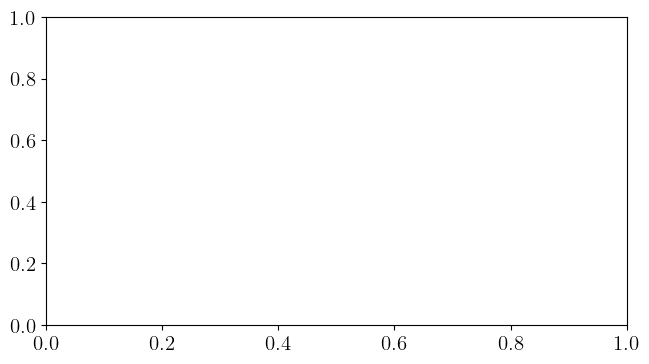

In [14]:
plt.rcParams.update({"figure.figsize": (7.5, 4),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]



for i in range(2):
    beta = betas[0][i]
    plt.plot(betas[i], btfr[i], label = fr"$\beta = {beta}$", ls = linestyle_tuple[i][1])
    plt.scatter(betas[i], btfr[i])
    
#plt.xticks([8,10,12])
plt.ylim(.556,.558)

plt.title(fr"Strong coupling ($J={Jvalue:2.2f}$)", fontsize = 12)
plt.xlabel(r"$\beta$")    
plt.ylabel("Beat freq.") 

plt.tick_params(which='both', axis="x", direction="in")
plt.tick_params(which='both', axis="y", direction="in")
plt.legend(frameon =False, loc = 6, fontsize = 12)    

figname = 'beatFr_regional_mag_FFT_strong.pdf'
figname1 = 'beatFr_regional_mag_FFT_strong.jpg'
#plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
#plt.savefig(figname1, bbox_inches='tight', pad_inches=0.0, dpi=300)

plt.show()

# Check the time evolution data

localmz_N8_J_0.6366197723675814.hdf5 0
localmz_N10_J_0.6366197723675814.hdf5 1
localmz_N12_J_0.6366197723675814.hdf5 2


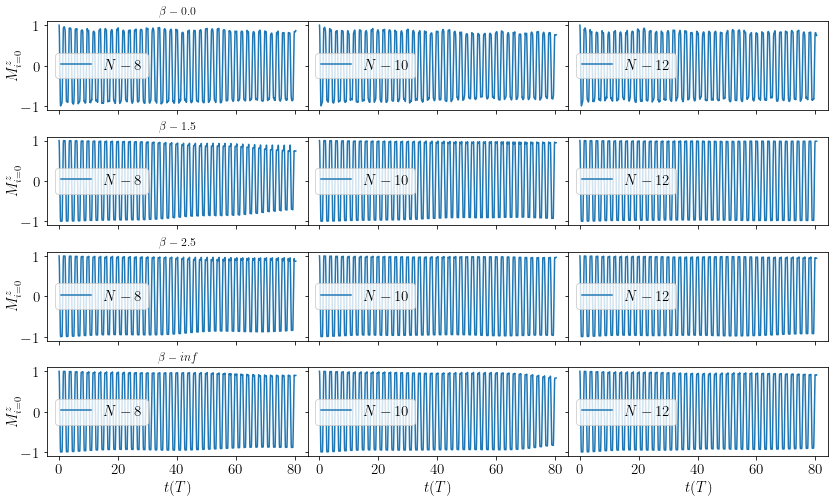

In [114]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import find_peaks
from lmfit.models import LinearModel

plt.rcParams.update({"figure.figsize": (14, 8),"text.usetex": True,"font.family": "sans-serif",
    "font.size": 15,"font.sans-serif": ["Helvetica"]})
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('dashed',                (0, (5, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

fig, axs = plt.subplots(4, 3, sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.0, hspace=0.3)

steps = 20001
freq_threshold = 0.1
legendftsize = 12

omega = 20.0
w = omega
T = 2 * np.pi/w


Ns = []
site = 0


with open("regional_mz_fft.txt", 'r') as fp:
    lines = fp.readlines()
    x = len(lines)
    btfr = np.zeros((4,x))
    
    for xx in range(0,x):
        filename = lines[xx][:-1]
        print(filename, xx)
        
        with h5py.File(filename, "r") as f:
            datas = f['mz'][()]
            times = f['times'][()]
            betas = f['betas'][()]
            N = f.attrs['N']
            Jvalue = f.attrs['Jvalue']   
            

        
        for b, beta in enumerate(betas):
            
            datap = np.zeros((N, len(times)))
            datap = datas[b][site][0]
        
            axs[b][0].set_title(fr"$\beta-{beta}$", fontsize=12)
            axs[b][xx].plot(times * 80/25, datap, label = fr"$N-{N}$")
            axs[b][xx].legend(loc = 6)
            



[axs[-1][i].set_xlabel('$t (T)$') for i in range(3)]
[axs[i][0].set_ylabel('$M^z_{i=0}$', labelpad =0) for i in range(4)]
            
            
#figname = 'regional_mag_FFT_strong.pdf'
figname1 = 'regional_mag_timeevolution_strong.jpg'
#plt.savefig(figname, bbox_inches='tight', pad_inches=0.0)
plt.savefig(figname1, bbox_inches='tight', pad_inches=0.0, dpi=300)
plt.show()